In [1]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_train = pd.read_csv(r"C:\Users\luis_\Documents\GitHub\data-science-projects\house-price-prediction\train.csv")
df_test = pd.read_csv(r"C:\Users\luis_\Documents\GitHub\data-science-projects\house-price-prediction\test.csv")

## Model Improvements

- Added GridSearchCV.
- Added RandomizedSearchCV.

## Visualizing the Dataset

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

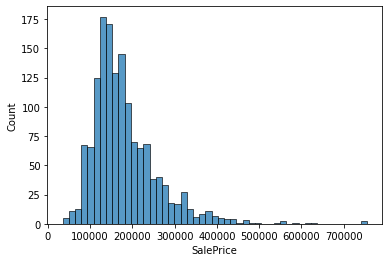

In [4]:
import seaborn as sns
sns.histplot(data=df_train, x="SalePrice")

## Data Wrangling

### 1) MSSubClass int > str
The "MSSubClass" category uses integers to specify types of dwelling, but these integers simply refer to categories.
We will change the datatype of this column from int to str.

<div style="float: left">

| Value  | Type of Dwelling |
|---|---|
| 20  | 1-STORY 1946 & NEWER ALL STYLES |
|  30 | 1-STORY 1945 & OLDER |
|  40 | 1-STORY W/FINISHED ATTIC ALL AGES |
etc.

</div>

In [5]:
# Transformation 1: int > str
df_train["MSSubClass"] = df_train["MSSubClass"].astype("str")

# Apply same to df_test
df_test["MSSubClass"] = df_test["MSSubClass"].astype("str")

In [6]:
# Check
df_train["MSSubClass"]

0       60
1       20
2       60
3       70
4       60
        ..
1455    60
1456    20
1457    70
1458    20
1459    20
Name: MSSubClass, Length: 1460, dtype: object

### 2) Make Id column index

In [55]:
df_train = df_train.set_index("Id")
df_test = df_test.set_index("Id")

## Preprocessing

### Numerical values

- Impute missing values using the median value of the column.
- Standardize the scale of each variable by removing the mean and scaling to unit variance (variance = 1).

In [8]:
# preprocessing for numeric columns
imp_median = SimpleImputer(strategy="median", add_indicator=True)
scaler = StandardScaler()

### Categorical variables

- Impute a "missing_value" string where values are missing.
- One hot encode all categorical variables.

In [9]:
# preprocessing for categorical columns
imp_constant = SimpleImputer(strategy="constant")
ohe = OneHotEncoder(handle_unknown="ignore")

### Create pipeline

Separate numerical and categorical variables, create pipeline to implement steps defined in preprocessing.

In [10]:
# select columns by data type
num_cols = make_column_selector(dtype_include="number")
cat_cols = make_column_selector(dtype_exclude="number")

In [11]:
# all preprocessing
preprocessor = make_column_transformer(
    (make_pipeline(imp_median, scaler), num_cols),
    (make_pipeline(imp_constant, ohe), cat_cols))

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipe = Pipeline([('preprocessing', preprocessor), ('clf', RandomForestRegressor())])

## Split "train" dataset into train, valid datasets
Splitting the dataset into train, valid early in the modelling process to run tests on various features.

In [16]:
# Define X (independent variables) and y (dependent variable)
X = df_train.drop(columns="SalePrice")
y = df_train["SalePrice"]

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2)

## Setting a baseline before optimization

In [17]:
pipe.fit(X_train, y_train)
print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Validation set score: ' + str(pipe.score(X_valid,y_valid)))

Training set score: 0.9827338786296768
Validation set score: 0.7893352839385438


## Feature Engineering

### 1) "SalesPrice" distribution
Since the target variable "SalesPrice" has a long-tail distribution, we should make predictions after conducting a log transform.

In [18]:
df_train_fe = df_train.copy()

In [19]:
# Log transform
df_train_fe["SalePrice"] = np.log(df_train_fe["SalePrice"])

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

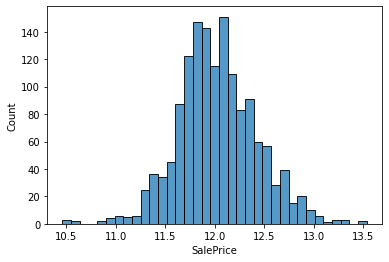

In [20]:
sns.histplot(data=df_train_fe, x="SalePrice")

In [21]:
print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Validation set score: ' + str(pipe.score(X_valid,y_valid)))

X_fe = df_train_fe.drop(columns="SalePrice")
y_fe = df_train_fe["SalePrice"]

from sklearn.model_selection import train_test_split
X_train_fe, X_valid_fe, y_train_fe, y_valid_fe = train_test_split(X_fe,y_fe, test_size=0.2)

pipe_fe = pipe
pipe_fe.fit(X_train_fe, y_train_fe)

print('Training set score with this feature: ' + str(pipe.score(X_train_fe,y_train_fe)))
print('Validation set score wth this feature: ' + str(pipe.score(X_valid_fe,y_valid_fe)))

Training set score: 0.9827338786296768
Validation set score: 0.7893352839385438
Training set score with this feature: 0.980065227795298
Validation set score wth this feature: 0.8934601051288217


### 2) Check skewness of all variables and log transform those that are tailed.

In [22]:
df_train.select_dtypes(include=["int64","float64"]).skew()

LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
SalePrice         1.882876
dtype: float64

<AxesSubplot:xlabel='LotFrontage', ylabel='Count'>

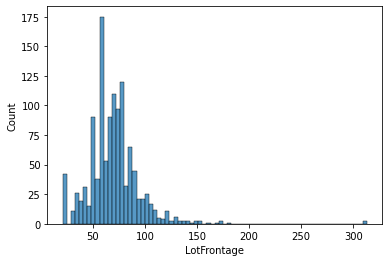

In [23]:
sns.histplot(data=df_train, x="LotFrontage")

In [24]:
df_train["SalePrice"].skew()

1.8828757597682129

In [45]:
import xgboost as xgb
import lightgbm as lgb

In [74]:
np.arange(100,1000,100)

array([100, 200, 300, 400, 500, 600, 700, 800, 900])

## Search Hyperparameters using RandomizedSearchCV

In [102]:
search_space_random = [
    {
        'clf': (xgb.XGBRegressor(), ),
        'clf__n_estimators': np.arange(100,1001,100),
        'clf__early_stopping_rounds': np.arange(10,51,10),
        'clf__learning_rate': [0.001, 0.01, 0.1],
        'clf__max_depth': np.arange(60,151,10),
    },
    {
        'clf': (lgb.LGBMRegressor(), ),
        'clf__n_estimators': np.arange(100,1001,100),
        'clf__early_stopping_rounds': np.arange(10,51,10),
        'clf__learning_rate': [0.001, 0.01, 0.1],
        'clf__max_depth': np.arange(60,151,10),
    },
    {
        'clf': (RandomForestRegressor(), ),
        'clf__n_estimators': np.arange(100,1001,100),
        'clf__oob_score': [True],
        'clf__bootstrap': [True],
        'clf__max_depth': np.arange(60,151,10),
        'clf__min_samples_leaf': np.arange(3,15),
        'clf__min_samples_split': np.arange(4,21,2)
    }
]

In [103]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(pipe, search_space_random, cv=5, n_jobs=8)

In [125]:
random_search.fit(X_train_fe,y_train_fe)
print('Training set score: ' + str(random_search.score(X_train_fe,y_train_fe)))
print('Validation set score: ' + str(random_search.score(X_valid_fe,y_valid_fe)))

Training set score: 0.9426944840086541
Validation set score: 0.8852737868657317


In [126]:
best_params = random_search.best_params_
print(best_params)

{'clf__oob_score': True, 'clf__n_estimators': 500, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 5, 'clf__max_depth': 110, 'clf__bootstrap': True, 'clf': RandomForestRegressor(max_depth=110, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=500, oob_score=True)}


## Analyze the results

First, record the best parameters and models.
Then, visualize model performance by reviewing the results for each hyperparameter, and set an improved search space in RandomizedSearchCV.

Improvements
--------------

- Try different estimators.
- Better cross-validation.

In [127]:
print(random_search.best_score_)

# Access the best set of parameters
best_params = random_search.best_params_
print(best_params)
# Stores the optimum model in best_pipe
best_pipe = random_search.best_estimator_
print(best_pipe)

0.8527817188122878
{'clf__oob_score': True, 'clf__n_estimators': 500, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 5, 'clf__max_depth': 110, 'clf__bootstrap': True, 'clf': RandomForestRegressor(max_depth=110, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=500, oob_score=True)}
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000

Then, visualize the results using a Pandas dataframe and seaborn.

In [128]:
result_df = pd.DataFrame.from_dict(random_search.cv_results_, orient='columns')
print(result_df.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_clf__oob_score', 'param_clf__n_estimators',
       'param_clf__min_samples_split', 'param_clf__min_samples_leaf',
       'param_clf__max_depth', 'param_clf__bootstrap', 'param_clf', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')


ValueError: Could not interpret value `param_clf__early_stopping_rounds` for parameter `x`

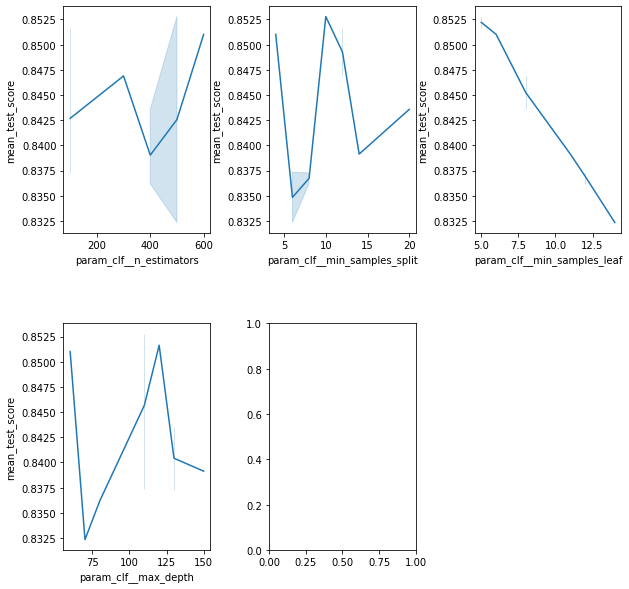

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 3, 1)
sns.lineplot(data=result_df, x='param_clf__n_estimators', y='mean_test_score', ax=ax)
ax = fig.add_subplot(2, 3, 2)
sns.lineplot(data=result_df, x='param_clf__min_samples_split', y='mean_test_score', ax=ax)
ax = fig.add_subplot(2, 3, 3)
sns.lineplot(data=result_df, x='param_clf__min_samples_leaf', y='mean_test_score', ax=ax)
ax = fig.add_subplot(2, 3, 4)
sns.lineplot(data=result_df, x='param_clf__max_depth', y='mean_test_score', ax=ax)
ax = fig.add_subplot(2, 3, 5)
sns.lineplot(data=result_df, x='param_clf__early_stopping_rounds', y='mean_test_score', ax=ax)
ax = fig.add_subplot(2, 3, 6)
sns.lineplot(data=result_df, x='param_clf__learning_rate', y='mean_test_score', ax=ax)

plt.show()

## Make Predictions

In [130]:
# Define X_test
X_test = df_test

In [131]:
# make predictions based on model
predictions = random_search.predict(X_test)

In [132]:
predictions

array([11.73522919, 11.94451763, 12.10527956, ..., 11.92714904,
       11.6358712 , 12.33543792])

In [133]:
d = {"Id":df_test.index,"SalePrice":predictions}
submission = pd.DataFrame(data=d)

# Revert log transform
submission["SalePrice"] = np.exp(submission["SalePrice"])

In [134]:
submission

,Id,SalePrice
0,1461,124895.065823
1,1462,153970.703899
2,1463,180824.018087
3,1464,180377.604303
4,1465,196894.060480
...,...,...
1454,2915,86769.243430
1455,2916,88901.231102
1456,2917,151319.540307
1457,2918,113082.305633


In [135]:
submission.to_csv("submission.csv",index=False)